In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import LinearOperator

%matplotlib widget


In [33]:
def radial_fdm_laplacian(r_max, n, left_bc = 'neumann'):
    """Generate laplacian in 2d polar coordinates, radial part.
    
    Discretize [0, r_max] with n+2 points, and apply
    neumann conditions on r=0 and Dirichlet on r=r_max, 
    resulting in an nxn matrix for the inner grid points.
    
    Args:
        r_max (float): right endpoint
        n (int): number of inner grid points
        left_bc (str, optional): 'neumann' for neumann BC, else dirichlet.
    
    Returns:
        ndarray: Laplacian as CRS matrix
        r: radial grid with endpoints
        G: transition matrix from inner to global grid
    
    """
    r = np.linspace(0, r_max, n+2)
    L = np.zeros((n,n+2))
    h = r[1]-r[0]
    
    for i in range(1,n+1):
        L[i-1,i+1] = (r[i]+h/2)/r[i]
        L[i-1,i-1] = (r[i]-h/2)/r[i]
        L[i-1,i] = -2 #-(r[i] + h/2)/r[i] - (r[i] - h/2)/r[i]
    
    G = np.zeros((n+2,n))
    G[1:-1,:] = np.eye(n)
    if left_bc == 'neumann_simple':
        G[0,0] = 1.0

    elif left_bc == 'neumann':
        G[0,0] = 1.0
        G[0,0] = 4/3
        G[0,1] = -1/3
    else:
        pass
    
    L1 = L @ G / h**2
    return L1, r, G

In [34]:
m = 0

L, r0, G = radial_fdm_laplacian(10, 100, left_bc = 'neumann_simple' if m == 0 else 'dirichlet')
r = r0[1:-1]
H = -0.5*L + np.diag(r**2/2 + .5*m**2/r**2)
R = np.diag(r)


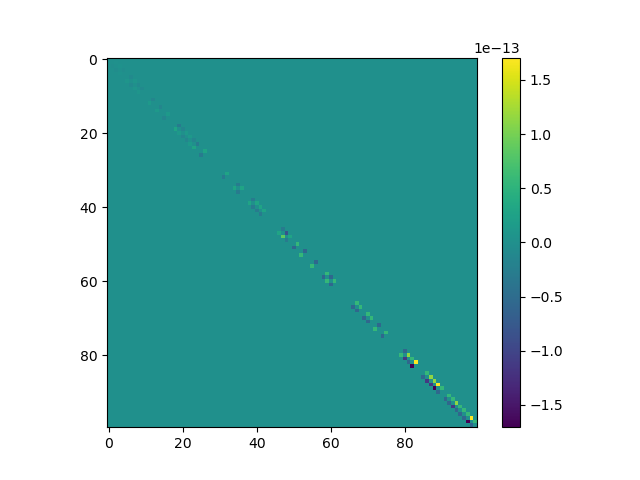

In [35]:
H2 = R @  H
plt.figure()
plt.imshow(H2 - H2.T)
plt.colorbar()
plt.show()

In [36]:
from scipy.linalg import eig, eigh
E, U = eigh((H2+H2.T)/2,R)
i = np.argsort(E)
E = E[i]
U = U[:,i]
E

array([  1.00120895,   3.00107011,   4.99589775,   6.98568789,
         8.97043104,  10.95011503,  12.924726  ,  14.89424888,
        16.85866766,  18.81796555,  20.7721251 ,  22.72112827,
        24.66495647,  26.60359063,  28.53701119,  30.46519815,
        32.38813114,  34.30579014,  36.21816192,  38.12528535,
        40.02750257,  41.92649879,  43.82825563,  45.74772789,
        47.70981883,  49.74078322,  51.85719885,  54.06375164,
        56.35788363,  58.73433294,  61.18739255,  63.71166991,
        66.30222998,  68.95454703,  71.66441814,  74.42788387,
        77.24116522,  80.10061606,  83.00268781,  85.94390331,
        88.92083753,  91.93010329,  94.96834077,  98.03220978,
       101.11838423, 104.22354809, 107.34439272, 110.47761507,
       113.61991663, 116.76800298, 119.91858373, 123.06837278,
       126.21408885, 129.35245611, 132.4802049 , 135.5940725 ,
       138.69080376, 141.76715172, 144.81987797, 147.84575278,
       150.84155489, 153.80407083, 156.73009369, 159.61

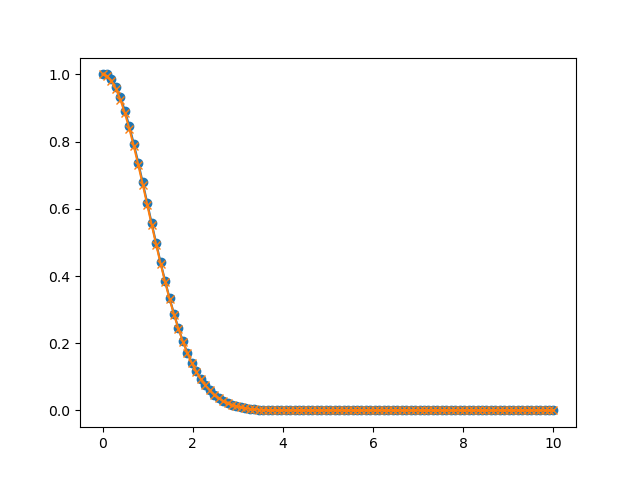

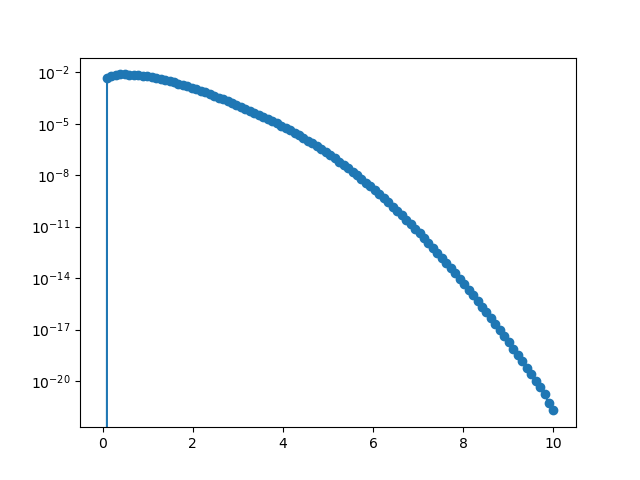

In [37]:
psi = G @ U[:,0]
psi = psi/psi[0]
psi_test = np.exp(-r0**2/2)

plt.figure()
plt.plot(r0,psi, 'o-')
plt.plot(r0,psi_test, 'x-')
plt.show()

plt.figure()
plt.semilogy(r0,np.abs(psi-psi_test), 'o-')
plt.show()

In [61]:
def study_convergence(bc='neumann_simple'):
    r_max = 10
    n_range = np.arange(100, 800, 100)
    h_range = np.zeros(n_range.shape)
    psi_error = np.zeros(n_range.shape)
    E_error = np.zeros(n_range.shape)
    
    for k, n_r in enumerate(n_range):
        ic(n_r)
        # construct operators
        m = 0
        L, r0, G = radial_fdm_laplacian(r_max, n_r, left_bc = bc if m == 0 else 'dirichlet')
        r = r0[1:-1]
        h_range[k] = r[1]-r[0]
        H = -0.5*L + np.diag(r**2/2 + .5*m**2/r**2)
        R = np.diag(r)
        H2 = R @ H
        #H2 = (H2 + H2.T)/2

        # diagonalize        
        E, U = eig(H2, R)
        i = np.argsort(E)
        E = E[i]
        U = U[:,i]
        
        # compute error
        psi_exact = np.exp(-r0**2/2)
        E_exact = 1.0
        psi = G @ U[:,0]
        psi = psi/psi[0]
        psi_error[k] = np.linalg.norm(psi-psi_exact)
        E_error[k] = np.abs(E[0]-E_exact)
        ic(n_r, psi_error[k], E_error[k], np.linalg.norm(psi-psi_exact))
        
    return h_range, psi_error, E_error


ic| n_r: 100
ic| n_r: 100
    psi_error[k]: 0.023680801341118805
    E_error[k]: 0.0012089535897956694
    np.linalg.norm(psi-psi_exact): 0.023680801341118805
ic| n_r: 200
ic| n_r: 200
    psi_error[k]: 0.010144012700803829
    E_error[k]: 0.00030808765603218546
    np.linalg.norm(psi-psi_exact): 0.010144012700803829
ic| n_r: 300
ic| n_r: 300
    psi_error[k]: 0.006092443210782183
    E_error[k]: 0.00013767613863802097
    np.linalg.norm(psi-psi_exact): 0.006092443210782183
ic| n_r: 400
ic| n_r: 400
    psi_error[k]: 0.0042210804420599645
    E_error[k]: 7.763637042579319e-05
    np.linalg.norm(psi-psi_exact): 0.0042210804420599645
ic| n_r: 500
ic| n_r: 500
    psi_error[k]: 0.00316706975184313
    E_error[k]: 4.9757564611230265e-05
    np.linalg.norm(psi-psi_exact): 0.00316706975184313
ic| n_r: 600
ic| n_r: 600
    psi_error[k]: 0.002500541582473693
    E_error[k]: 3.4585117392404996e-05
    np.linalg.norm(psi-psi_exact): 0.002500541582473693
ic| n_r: 700
ic| n_r: 700
    psi_error[k]

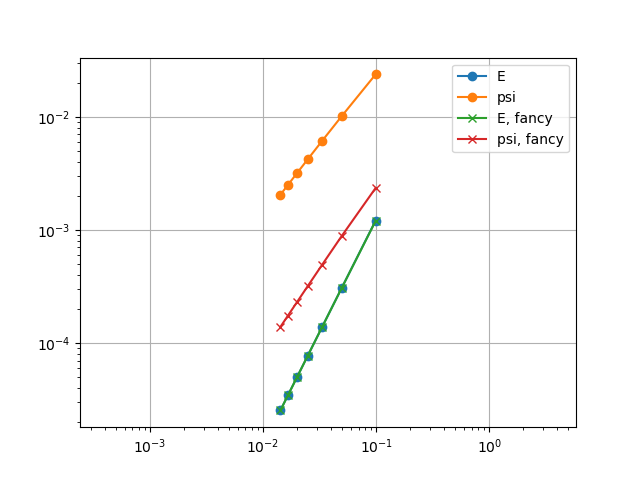

ic| np.polyfit(np.log(h_range), np.log(psi_error), 1): array([ 1.26505207, -0.80469752])
ic| np.polyfit(np.log(h_range), np.log(psi_error2), 1): array([ 1.46147062, -2.65885627])
ic| np.polyfit(np.log(h_range), np.log(E_error), 1): array([ 1.99370518, -2.1049246 ])
ic| np.polyfit(np.log(h_range), np.log(E_error2), 1): array([ 1.99026253, -2.11828779])


array([ 1.99026253, -2.11828779])

In [62]:
h_range, psi_error, E_error = study_convergence('neumann_simple')
h_range2, psi_error2, E_error2 = study_convergence('neumann')
plt.figure()
plt.loglog(h_range, np.abs(E_error), 'o-', label='E')
plt.loglog(h_range, np.abs(psi_error), 'o-', label='psi')
plt.loglog(h_range2, np.abs(E_error2), 'x-', label='E, fancy')
plt.loglog(h_range2, np.abs(psi_error2), 'x-', label='psi, fancy')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
        
        
ic(np.polyfit(np.log(h_range), np.log(psi_error), 1))
ic(np.polyfit(np.log(h_range), np.log(psi_error2), 1))
ic(np.polyfit(np.log(h_range), np.log(E_error), 1))
ic(np.polyfit(np.log(h_range), np.log(E_error2), 1))
    

In [54]:
E_error - E_error2

array([ 6.53864557e-02,  5.75817274e-06,  2.43417378e-07,  2.58328001e-08,
        2.38010378e-09, -9.95886040e-10, -1.28799993e-09, -1.07124654e-09,
       -8.21474111e-10, -6.19805318e-10])

In [60]:
ic(np.polyfit(np.log(h_range), np.log(psi_error2), 1))

ic| np.polyfit(np.log(h_range), np.log(psi_error2), 1): array([ 1.63908184, -1.97519675])


array([ 1.63908184, -1.97519675])